In [38]:
import time
import math
import cv2
import sys, os
import os.path

from skimage import io
from skimage.color import rgb2gray

from sklearn import manifold

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.distributions import Normal, Categorical
import torchvision.transforms as transforms

sys.path.append(os.path.abspath('../'))

from synthetic import VAE
from utils import Config, str2bool

IMG_DIR="/tmp/capture_20180813_1912"
SIM_IMG_DIR="/tmp/capture_20180809_1039"
VAE_MODEL = "/tmp/synthetic_20180727_1600/vae.pt"
CFG_PATH = "../configs/ppo_vae.json"

In [39]:
class CaptureDataset(Dataset):
    """Capture dataset."""

    def __init__(self, root_dir):
        """
        Args:
            root_dir (string): Directory with all the images.
        """
        self.root_dir = root_dir
        self.img_names = []
        listing = os.listdir(root_dir)
        for files in listing:
            if files.endswith('.jpeg'):
                self.img_names.append(files[:len(files)-len('.jpeg')])
        self.img_names.sort(key=int)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.img_names[idx] + '.jpeg')
        image = rgb2gray(io.imread(img_name))
        sample = {'image': image}
        return sample

In [40]:
# load dataset 
dataset = CaptureDataset(IMG_DIR)
sim_dataset = CaptureDataset(SIM_IMG_DIR)
print("Dataset loaded...")


# load configuration
cfg = Config(CFG_PATH)

# load model
device = torch.device("cpu")
vae = VAE(cfg).to(device)

vae.load_state_dict(
    torch.load(VAE_MODEL, map_location='cpu'),
)

print("Model loaded...")

Dataset loaded...
Model loaded...


In [43]:
# inference, find the latent values for our dataset
vae.eval()
latent = torch.zeros( [len(sim_dataset.img_names), 1, 32])

for i, data in enumerate(sim_dataset, 0):
    img = sim_dataset[i]["image"] 
    img = (torch.from_numpy(np.array([img[50:]], np.uint8))/255.0).float()
    img = img.to(device).unsqueeze(0)

    vae_latent, encoded, vae_mean, vae_logvar = vae(img, deterministic=True)
#     plt.imshow(np.squeeze(encoded.detach()))
#     plt.show()
    
    latent[i,:,:] = vae_latent

print("Latent values infered...")
#     show latent space values
#     vae_latent_image = torch.unsqueeze(vae_latent, 0)
#     plt.imshow(transforms.ToPILImage()(vae_latent_image))
#     plt.show()

Latent values infered...


Computing t-SNE embedding...
Plotting t-SNE visualization...


<Figure size 432x288 with 0 Axes>

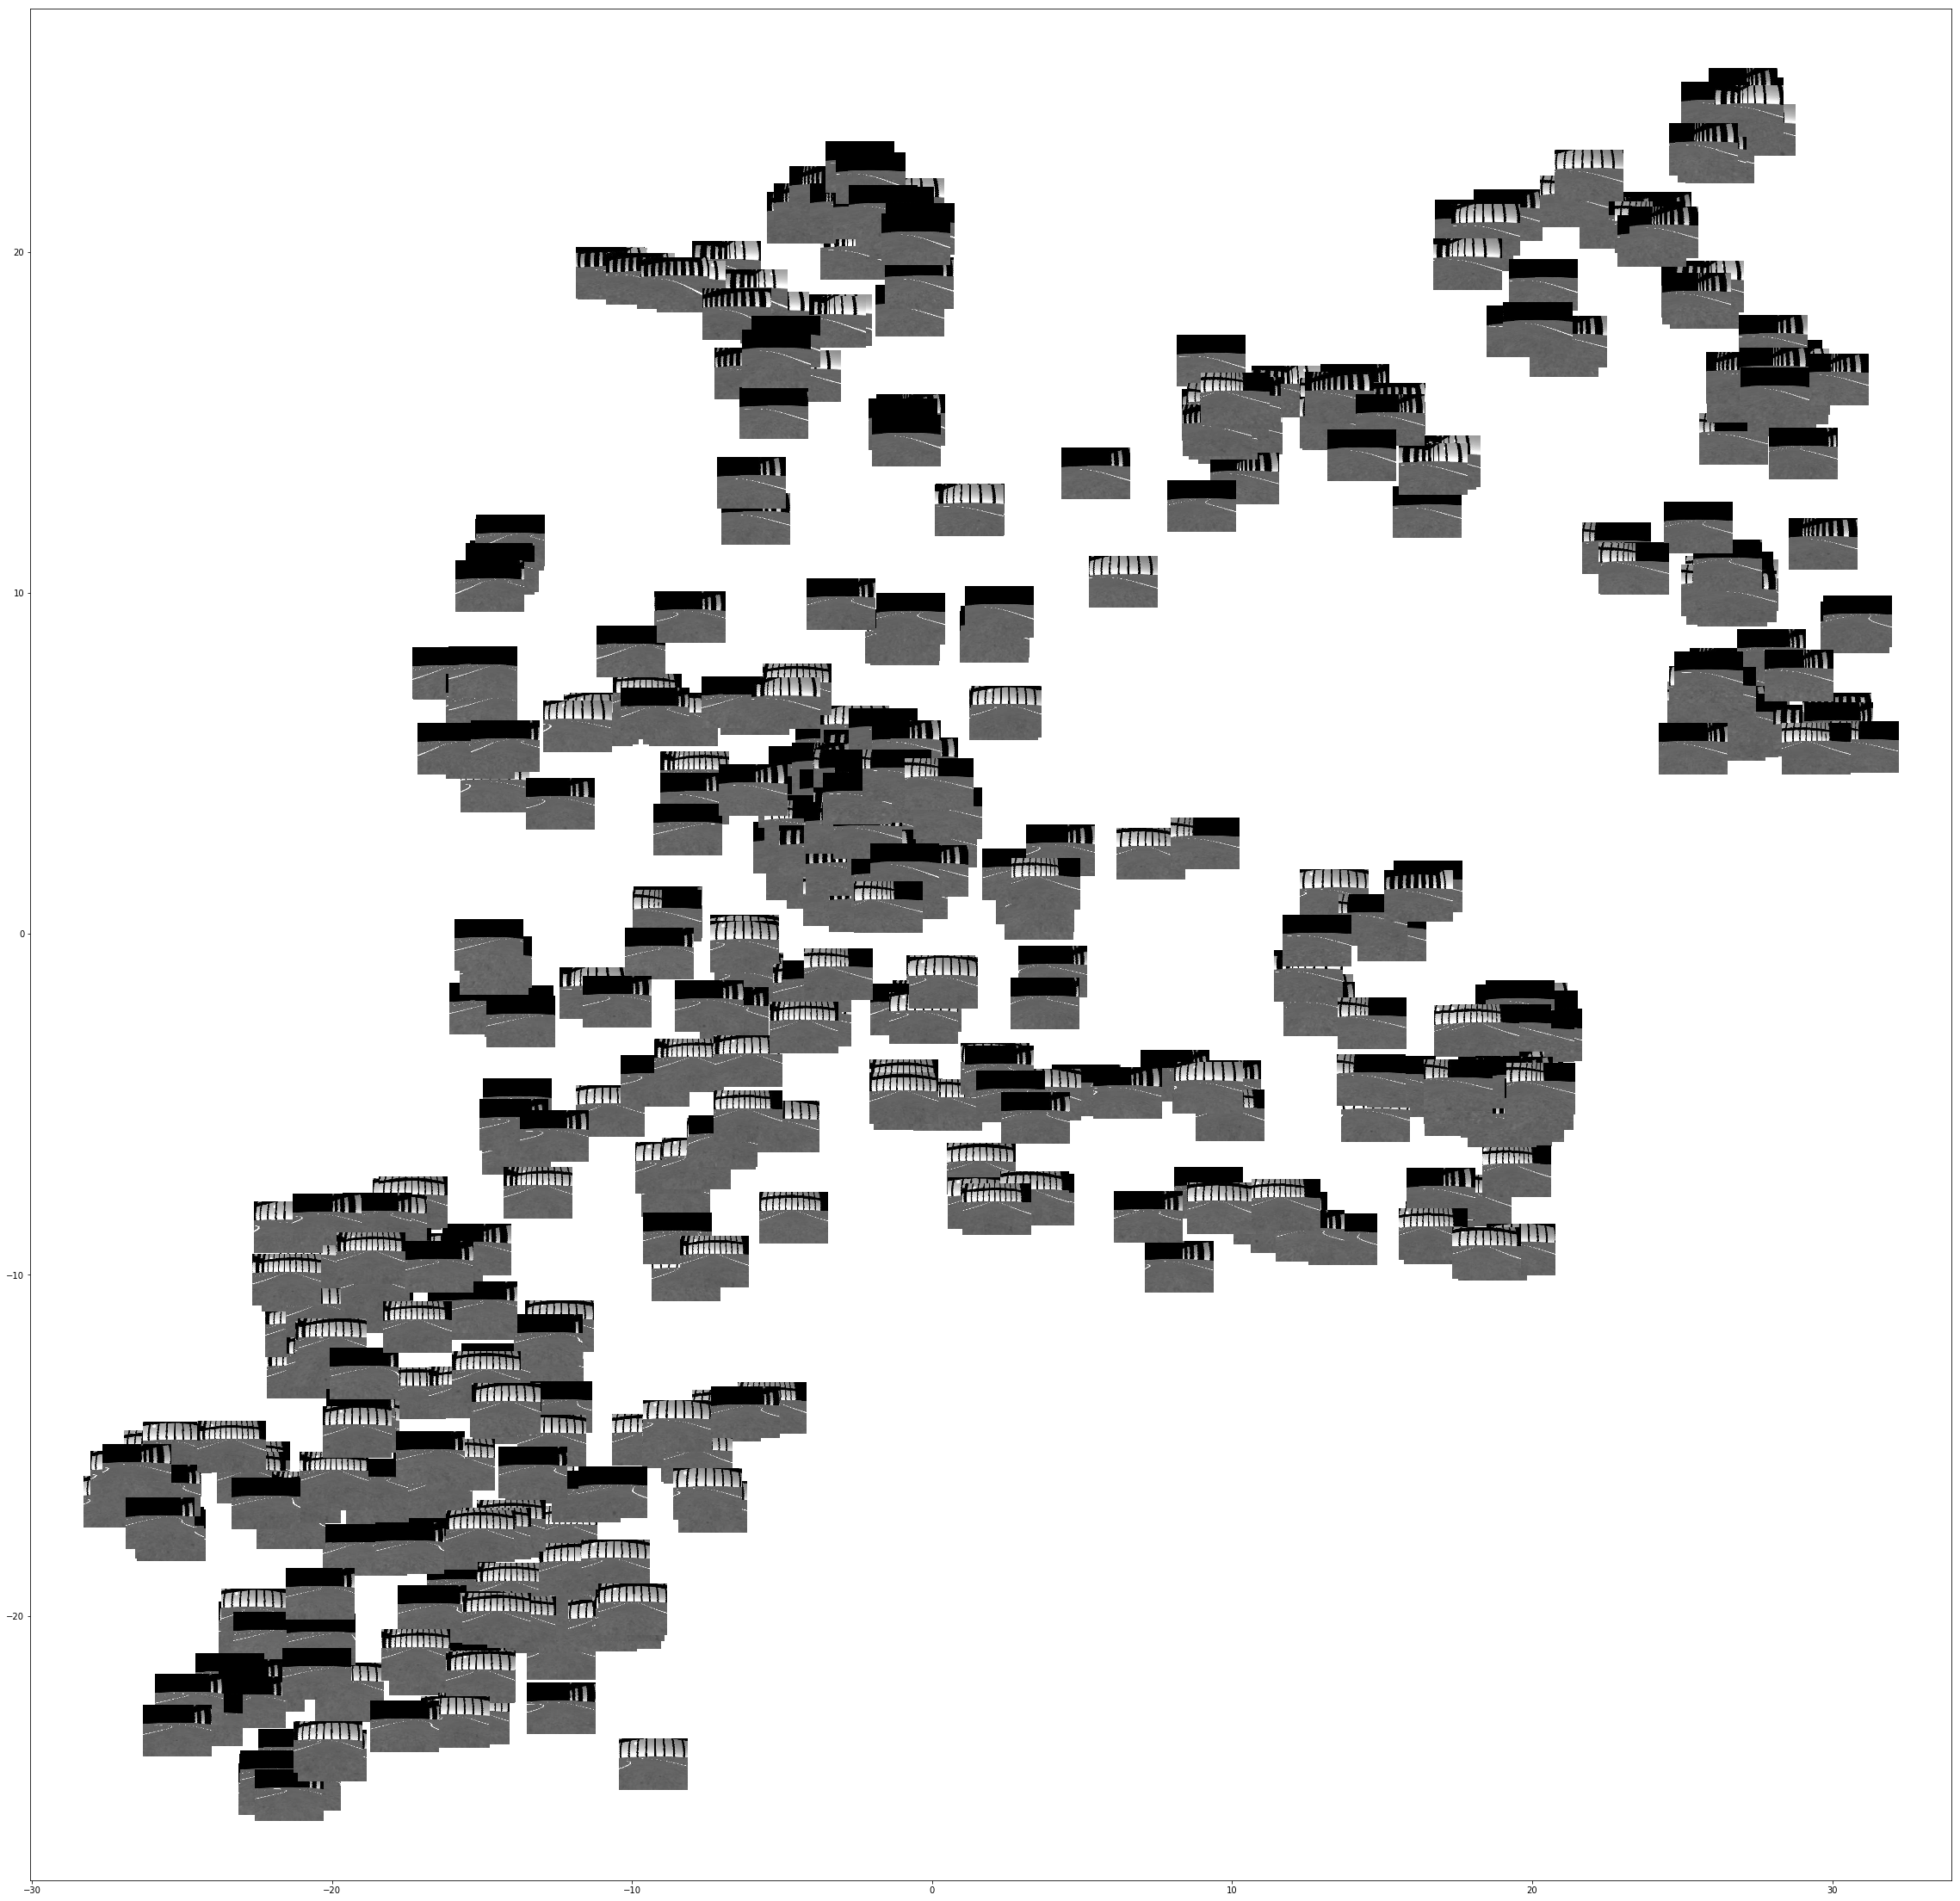

In [44]:
plt.gray()

# Show dataset images with T-sne projection of latent space encoding
def computeTSNEProjectionOfLatentSpace(X, annotation_images, display=True):
    
    # Compute t-SNE embedding of latent space
    print("Computing t-SNE embedding...")
    X_tsne = manifold.TSNE(n_components=2).fit_transform(X.reshape(-1,32))
    
    # Plot images according to t-sne embedding
    if display:
        print("Plotting t-SNE visualization...")
        fig, ax = plt.subplots(1,1, figsize=(40,40))
        imscatter(X_tsne[:, 0], X_tsne[:, 1], ax, annotation_images, 0.5)
    else:
        return X_tsne
    
# Scatter with images instead of points
def imscatter(x, y, ax, images, zoom): 
    annotated_images = []
    for i in range(len(x)):
        x0, y0 = x[i], y[i]
        # Convert to image
        # Note: OpenCV uses BGR and plt uses RGB
        img = images[i,:,:]
        img = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        annotated_images.append(ax.add_artist(ab))

    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()


# images = torch.zeros( [len(sim_dataset.img_names), 120, 160])
images = np.zeros([len(sim_dataset.img_names), 120, 160])

# create a tensor of the inputs
for i, data in enumerate(sim_dataset, 0):
    img = sim_dataset[i]["image"] 
    images[i,:, :] = np.array([img])

computeTSNEProjectionOfLatentSpace(latent.detach().numpy(), images)